In [2]:
from IPython.display import clear_output
!pip install visualkeras
clear_output()

In [3]:
import os
import random
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2
import visualkeras

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, Flatten, GlobalAveragePooling2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

SEED = 15
BATCH_SIZE = 8

In [4]:
!pip install --upgrade ipywidgets
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [5]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in tqdm(images, desc = 'images' ):
        full_path.append(os.path.join(path, i))
        
    return full_path


data_healthy = create_images_list('../Down_Syndrome/archive/healty/healty')
data_down = create_images_list('../Down_Syndrome/archive/downSyndorme/downSyndrome')

# look-up table
disease_classes = {0:'healthy', 1 : 'down' }

data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_healthy) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_down) , "label": 1 }) ], ignore_index = True)


data_df = shuffle(data_df).reset_index(drop = True)


images:   0%|          | 0/1499 [00:00<?, ?it/s]

images:   0%|          | 0/1500 [00:00<?, ?it/s]

In [6]:
# Creating random 4 sample from a dataframe


def create_img_label_sample(data, index):
    
    img = cv2.imread(data['img'][index])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = disease_classes[data_df['label'][index]]
    
    return img, label

In [7]:
def create_random_samples(data):
    
    idx1,idx2,idx3,idx4 =np.random.permutation(data.shape[0])[:4]
    
    fig, axs = plt.subplots(1,4, figsize = (12,5), dpi = 300)
    
    img1, name1 = create_img_label_sample(data, idx1)
    img2, name2 = create_img_label_sample(data, idx2)
    img3, name3 = create_img_label_sample(data, idx3)
    img4, name4 = create_img_label_sample(data, idx4)

    
    axs[0].imshow(img1)
    axs[0].set_title(name1)
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title(name2)
    axs[1].axis('off')

    axs[2].imshow(img3)
    axs[2].set_title(name3)
    axs[2].axis('off')

    axs[3].imshow(img4)
    axs[3].set_title(name4)
    axs[3].axis('off')
    
    plt.show()

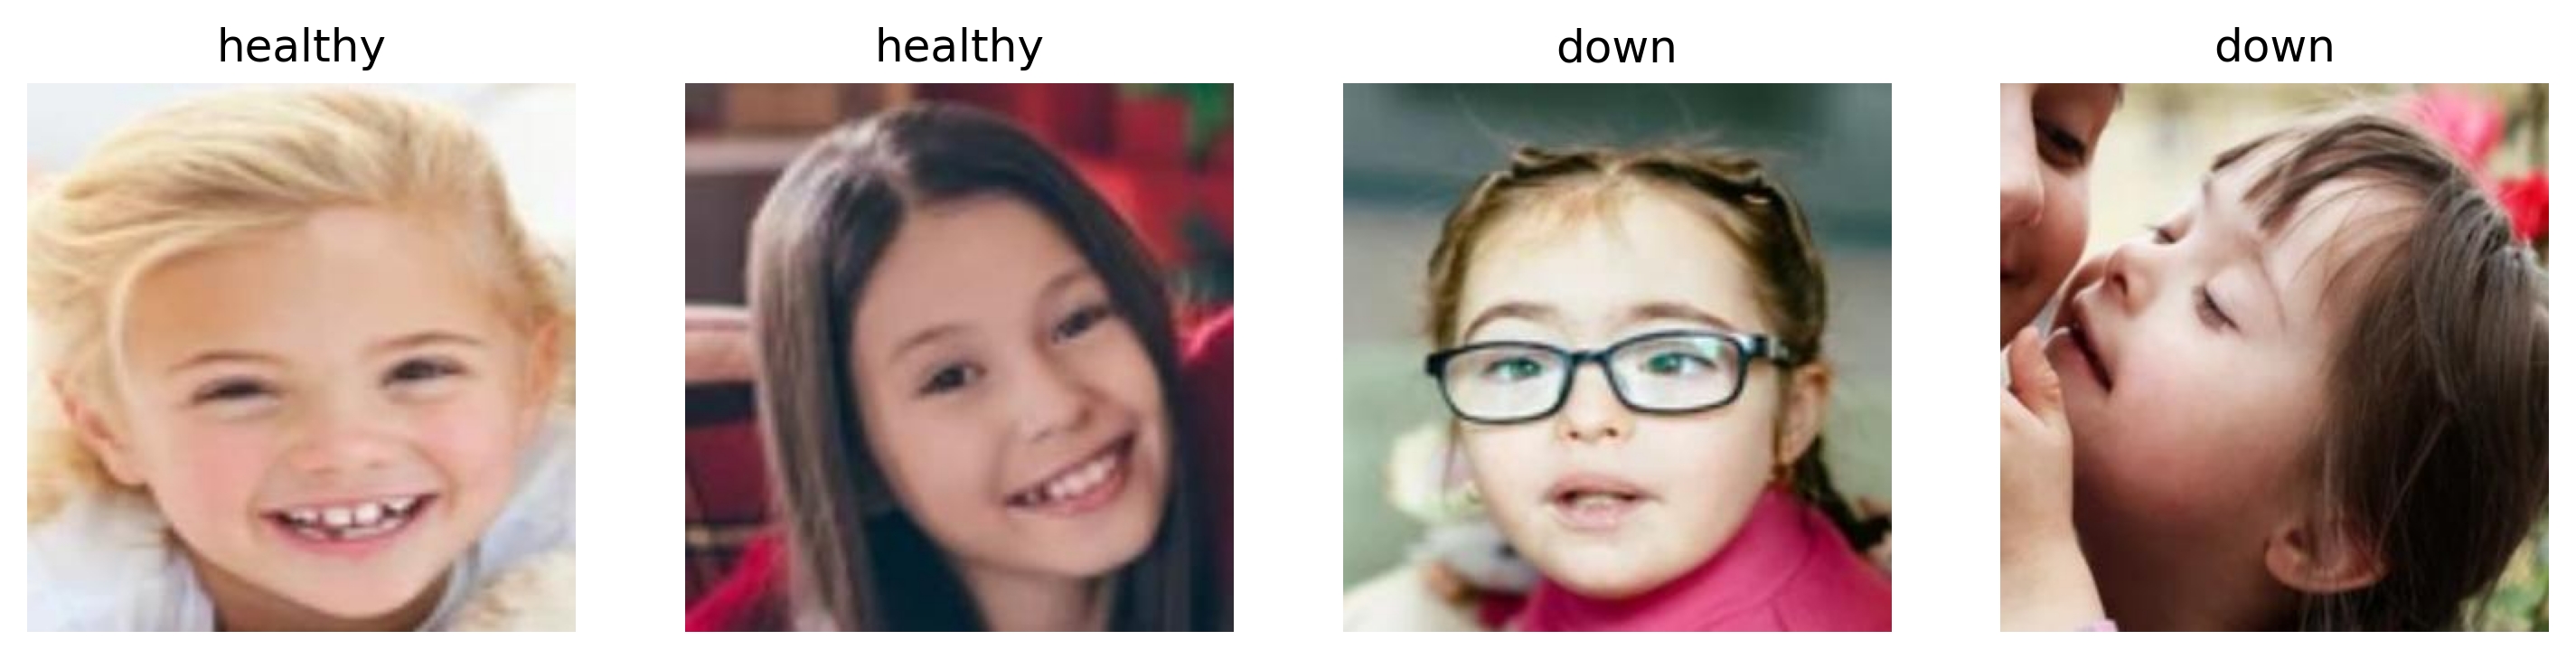

In [23]:
# Random samples

create_random_samples(data_df)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data_df['img'], data_df['label'], test_size = 0.15,  random_state = SEED)

print("train images: ", X_train.shape[0])
print("test images: ", X_test.shape[0])

train images:  2549
test images:  450


In [10]:
def img_preprocessing(image, label):
    
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (250,250))
    img = img/255.0
    
    return img, label

In [11]:
# Creating dataset loaders

train_loader = tf.data.Dataset.from_tensor_slices(( X_train, y_train) )
train_dataset = (train_loader.map(img_preprocessing).batch(BATCH_SIZE).shuffle(X_train.shape[0]).prefetch(BATCH_SIZE))

test_loader = tf.data.Dataset.from_tensor_slices(( X_test, y_test) )
test_dataset = (test_loader.map(img_preprocessing).batch(BATCH_SIZE).prefetch(BATCH_SIZE))

In [12]:
In = Input(shape=(250, 250, 3))

conv2 = Conv2D(32, 2, padding = 'same')(In)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(64, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


conv2 = Conv2D(128, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)

conv2 = Conv2D(256, 2, padding = 'same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('elu')(conv2)
conv2 = MaxPooling2D(2)(conv2)


pool = GlobalAveragePooling2D()(conv2)
drop = Dropout(0.6)(pool)
dense1 = Dense(64, activation = 'relu')(drop)
dense1 = Dense(64, activation = 'relu')(dense1)
Out = Dense(1, activation = 'sigmoid')(dense1)

model = Model(inputs = In, outputs = Out)

model.compile(optimizer  = tf.keras.optimizers.Adam(), loss = 'binary_crossentropy', metrics = ['accuracy','AUC','Precision','Recall'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 32)      416       
                                                                 
 batch_normalization (Batch  (None, 250, 250, 32)      128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 250, 250, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 125, 125, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      8256  

In [35]:
#Plotting the model 

plt.figure(dpi = 100)
visualkeras.layered_view(model ,  spacing = 50,  scale_z = 1, scale_xy = 2 , legend=True, type_ignore=[BatchNormalization, Activation, Dropout])

AttributeError: 'ImageFont' object has no attribute 'getsize'

<Figure size 640x480 with 0 Axes>

In [16]:
# Training

my_callbacks = [EarlyStopping(monitor = 'loss', patience = 8, min_delta = 0.0001)]

hist = model.fit(train_dataset, epochs = 10, verbose =1, callbacks = my_callbacks)

Epoch 1/10
319/319 [==============================] - 846s 3s/step - loss: 0.6626 - accuracy: 0.6210 - auc: 0.6606 - precision: 0.6186 - recall: 0.6225
Epoch 2/10
319/319 [==============================] - 1454s 5s/step - loss: 0.6271 - accuracy: 0.6465 - auc: 0.7028 - precision: 0.6365 - recall: 0.6761
Epoch 3/10
319/319 [==============================] - 457s 1s/step - loss: 0.6044 - accuracy: 0.6736 - auc: 0.7345 - precision: 0.6706 - recall: 0.6769
Epoch 4/10
319/319 [==============================] - 1447s 5s/step - loss: 0.5999 - accuracy: 0.6799 - auc: 0.7407 - precision: 0.6717 - recall: 0.6982
Epoch 5/10
319/319 [==============================] - 3286s 10s/step - loss: 0.5956 - accuracy: 0.6732 - auc: 0.7432 - precision: 0.6610 - recall: 0.7053
Epoch 6/10
319/319 [==============================] - 2106s 7s/step - loss: 0.5892 - accuracy: 0.6905 - auc: 0.7554 - precision: 0.6832 - recall: 0.7053
Epoch 7/10
319/319 [==============================] - 197s 610ms/step - loss: 0.586

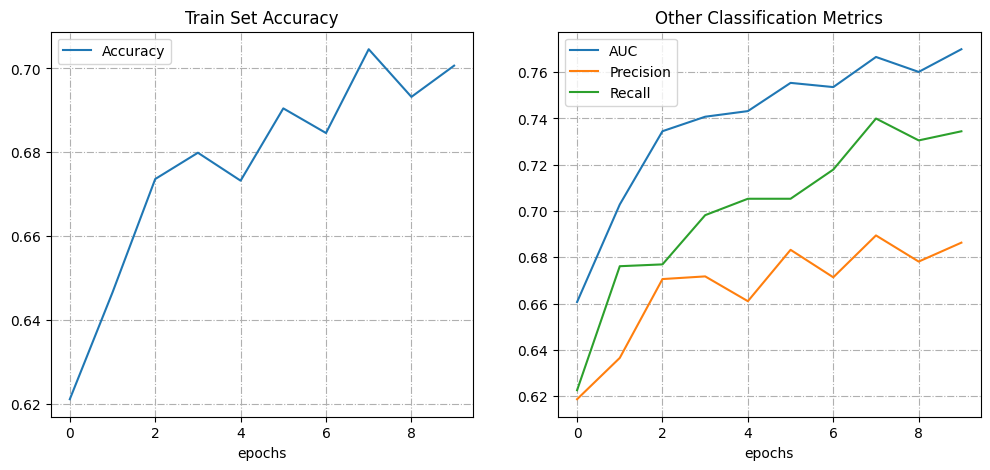

In [17]:

fig, axs = plt.subplots(1,2, figsize = (12,5), dpi = 100)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Train Set Accuracy")
axs[0].plot(hist.history['accuracy'])
axs[0].set_xlabel("epochs")
axs[0].legend(["Accuracy"])


axs[1].grid(linestyle="dashdot")
axs[1].set_title("Other Classification Metrics")
axs[1].plot(hist.history['auc'])
axs[1].plot(hist.history['precision'])
axs[1].plot(hist.history['recall'])
axs[1].set_xlabel("epochs")
axs[1].legend(["AUC", "Precision", "Recall"])

In [18]:
# Test set evaluation

test_eval = model.evaluate(test_dataset)

print('test accuracy : {0:.3f} %'.format(test_eval[1]*100))
print('test auc : {0:.3f}'.format(test_eval[2]))
print('test precision : {0:.3f}'.format(test_eval[3]))
print('test recall : {0:.3f}'.format(test_eval[4]))

57/57 [==============================] - 9s 151ms/step - loss: 0.6770 - accuracy: 0.6156 - auc: 0.8101 - precision: 0.5759 - recall: 0.9524
test accuracy : 61.556 %
test auc : 0.810
test precision : 0.576
test recall : 0.952


In [19]:
# Test set prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)
pred = model.predict(test_take1)
pred_ = np.round(pred)

y_test_take = []
for x in range(len(test_take1_)):
    y_test_take.extend(test_take1_[x][1].numpy())

57/57 [==============================] - 8s 133ms/step


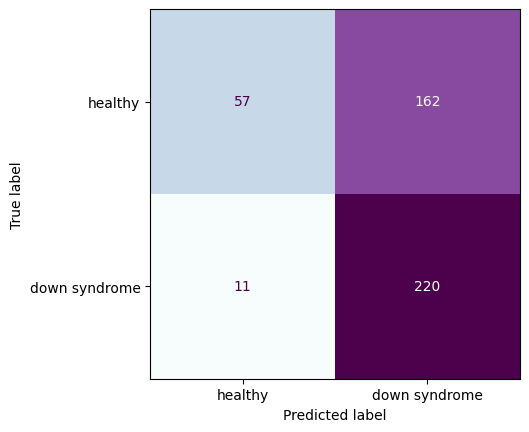

In [20]:
# Plotting the confusion matrix 

cm = confusion_matrix(y_test_take, pred_)
cmd = ConfusionMatrixDisplay(cm, display_labels= ['healthy','down syndrome'])
cmd.plot(cmap = 'BuPu',colorbar = False )